In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools

import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import shapiro
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import cross_val_score,train_test_split
from pandas import plotting
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.style.use('fivethirtyeight')
from sklearn.metrics import ConfusionMatrixDisplay
#from mlxtend.plotting import plot_confusion_matrix
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

In [2]:
beans_df = pd.read_csv('train.csv')
print(f"The shape of the train dataset is {beans_df.shape}")

The shape of the train dataset is (10834, 18)


In [3]:
beans_df.head(3)

,ID,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,y
0,0,58238,971.303,397.202654,186.945510,2.124697,0.882317,58977,272.306674,0.604756,0.987470,0.775723,0.685561,0.006820,0.000929,0.469994,0.998595,HOROZ
1,1,44515,757.601,265.590470,213.967453,1.241266,0.592420,44780,238.071960,0.771745,0.994082,0.974620,0.896387,0.005966,0.002376,0.803510,0.997370,SEKER
2,2,31662,653.783,239.902428,168.421505,1.424417,0.712136,32034,200.781748,0.801407,0.988387,0.930853,0.836931,0.007577,0.002293,0.700453,0.997737,DERMASON


In [4]:
beans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10834 entries, 0 to 10833
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10834 non-null  int64  
 1   Area             10834 non-null  int64  
 2   Perimeter        10834 non-null  float64
 3   MajorAxisLength  10834 non-null  float64
 4   MinorAxisLength  10834 non-null  float64
 5   AspectRation     10834 non-null  float64
 6   Eccentricity     10834 non-null  float64
 7   ConvexArea       10834 non-null  int64  
 8   EquivDiameter    10834 non-null  float64
 9   Extent           10834 non-null  float64
 10  Solidity         10834 non-null  float64
 11  roundness        10834 non-null  float64
 12  Compactness      10834 non-null  float64
 13  ShapeFactor1     10834 non-null  float64
 14  ShapeFactor2     10834 non-null  float64
 15  ShapeFactor3     10834 non-null  float64
 16  ShapeFactor4     10834 non-null  float64
 17  y           

In [5]:
beans_df['y'].value_counts()

DERMASON    2837
SIRA        2109
SEKER       1621
HOROZ       1488
CALI        1304
BARBUNYA    1057
BOMBAY       418
Name: y, dtype: int64

In [6]:
beans_df.duplicated().sum()

0

In [7]:
feats = list(set(beans_df.columns.to_list()) - set(['ID']) - set(['y']))
len(feats)

16

,Feature,Skewness
0,Area,2.970246
1,ConvexArea,2.960315
2,ShapeFactor4,-2.628540
3,Solidity,-2.507634
4,MinorAxisLength,2.251468
5,EquivDiameter,1.971378
6,Perimeter,1.650773
7,MajorAxisLength,1.390286
8,Eccentricity,-1.075626
9,Extent,-0.900892


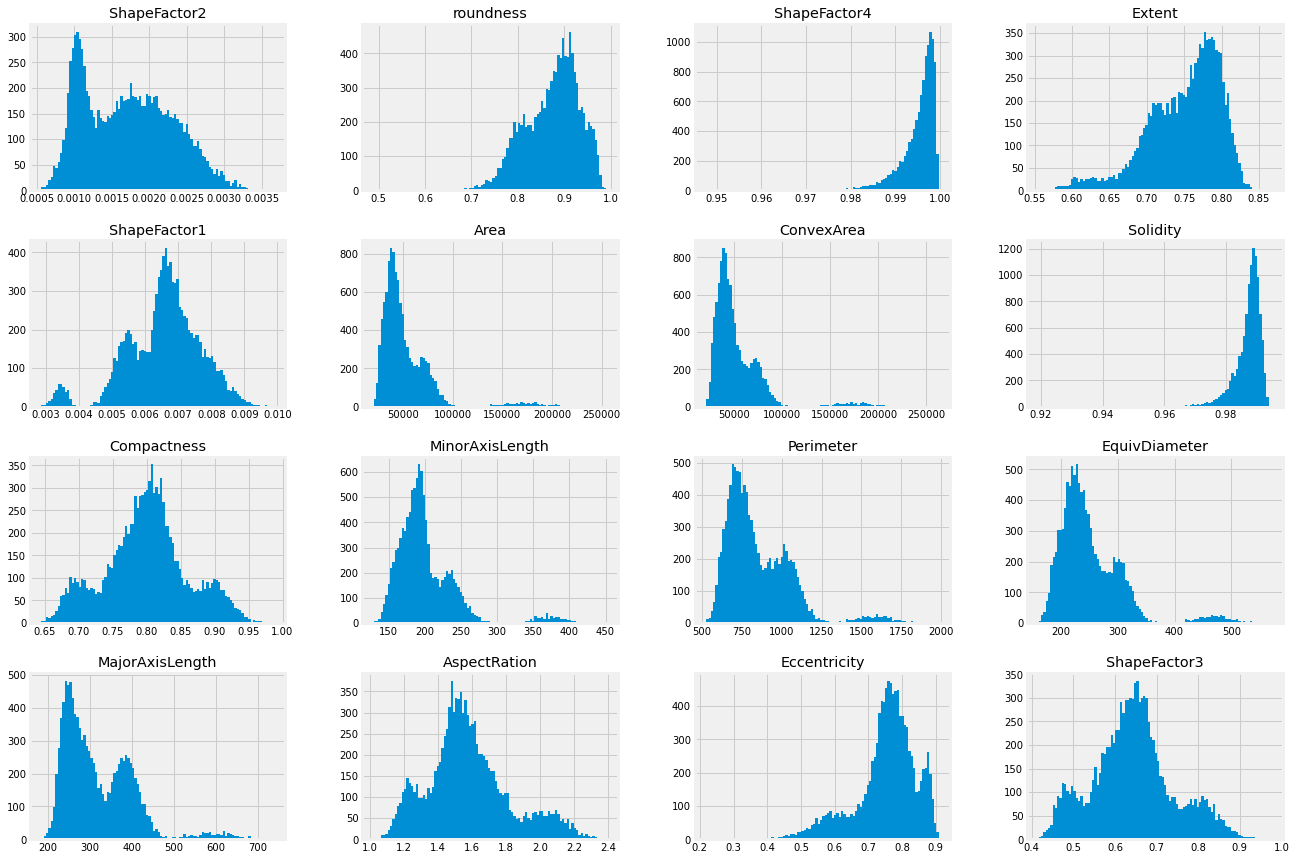

In [8]:
beans_df[feats[:16]].hist(bins = 100, figsize = (20, 15));

beans_df.skew().sort_values(key=abs, ascending=False).reset_index().rename(columns = {0 : 'Skewness', 'index' : 'Feature'})

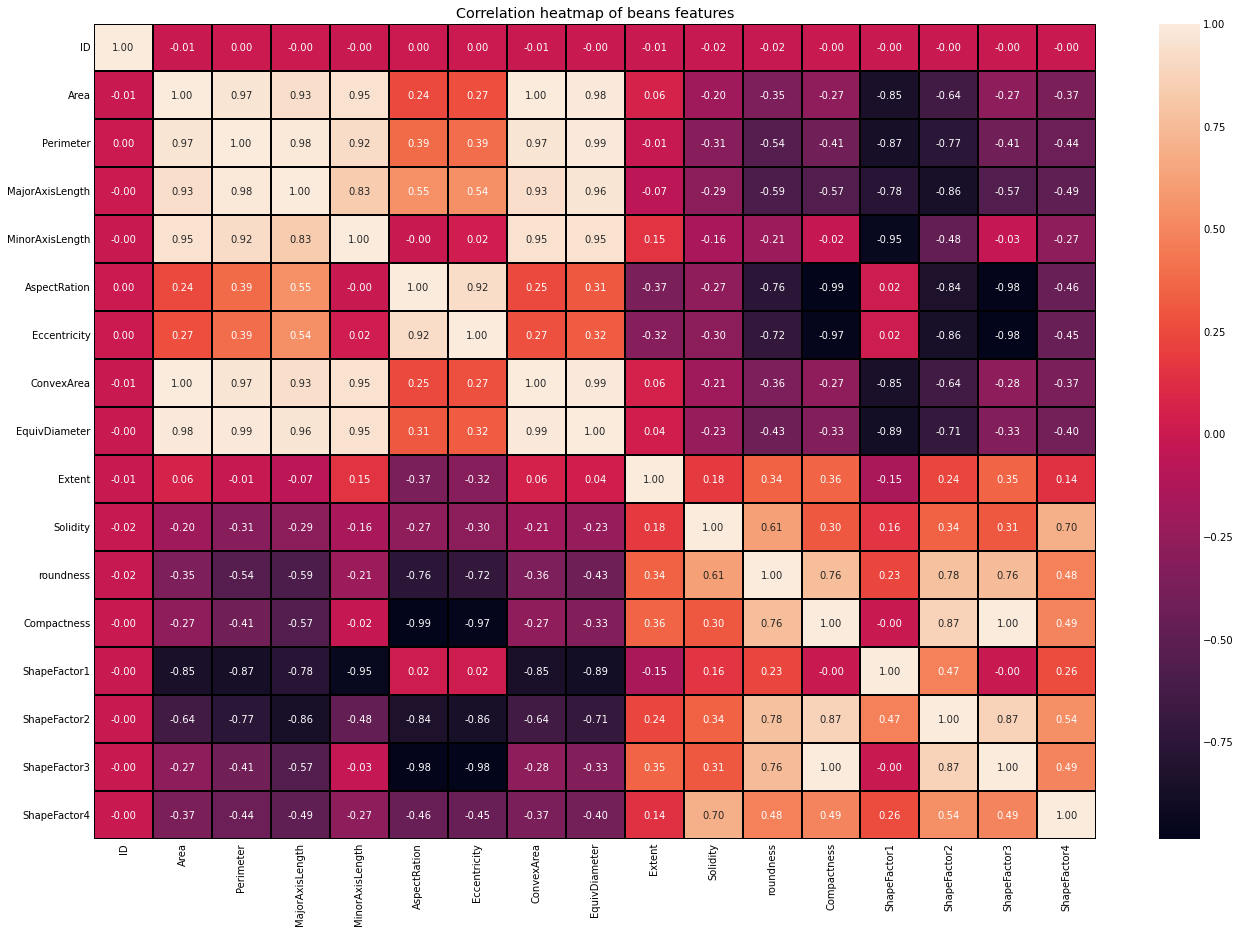

In [9]:
corr_matrix = beans_df.corr()

plt.subplots(figsize = (20, 15))
plt.title('Correlation heatmap of beans features')
sns.heatmap(corr_matrix, 
           xticklabels = corr_matrix.columns.values,
           yticklabels = corr_matrix.columns.values, 
           linewidth = 0.1, annot=True, fmt='.2f', linecolor='black');

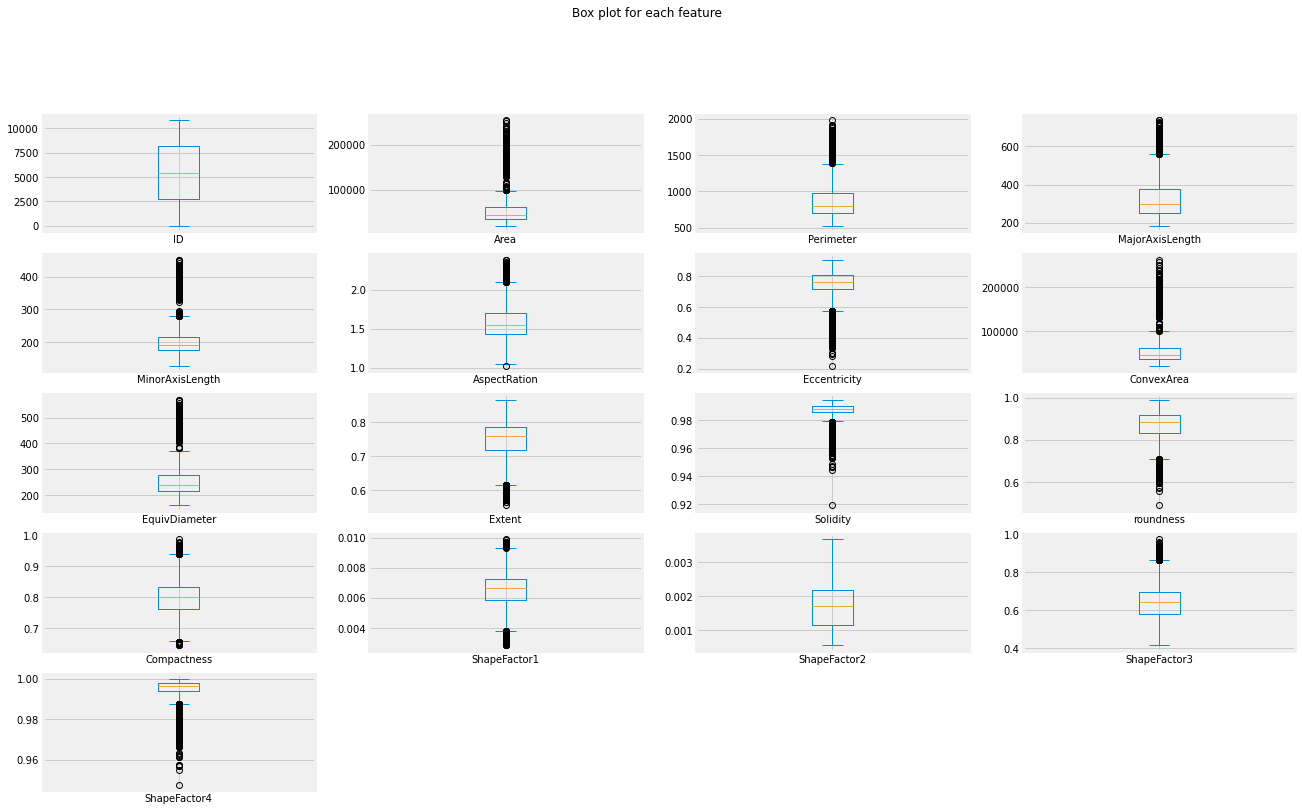

In [10]:
beans_df.plot(kind = 'box',
              subplots = True,
              layout = (6, 4),
              sharex = False,
              sharey = False,
              figsize = (20, 15),
              title = 'Box plot for each feature');

In [11]:
beans_df.describe()

,ID,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
count,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000
mean,5416.500000,53095.675189,855.274892,320.036169,202.410342,1.581294,0.750588,53816.205926,253.123583,0.749937,0.987152,0.873647,0.800244,0.006559,0.001718,0.644139,0.995083
std,3127.650742,29542.542580,214.991122,85.961630,45.113965,0.244314,0.091481,29999.710739,59.433080,0.048949,0.004626,0.059344,0.061228,0.001127,0.000593,0.098268,0.004306
min,0.000000,20420.000000,524.932000,183.601165,129.576207,1.024868,0.218951,20684.000000,161.243764,0.555315,0.919246,0.489618,0.645368,0.002856,0.000564,0.416499,0.947687
25%,2708.250000,36343.500000,703.601250,253.501071,175.927024,1.432985,0.716250,36731.250000,215.113880,0.718778,0.985627,0.833479,0.763378,0.005888,0.001161,0.582747,0.993690
50%,5416.500000,44645.000000,793.739500,296.377365,192.525040,1.550761,0.764314,45148.000000,238.419335,0.760141,0.988290,0.883472,0.801428,0.006643,0.001700,0.642287,0.996397
75%,8124.750000,61295.000000,975.517500,376.068399,217.315195,1.703029,0.809450,62251.500000,279.362162,0.786871,0.990014,0.916883,0.834068,0.007268,0.002169,0.695670,0.997895
max,10833.000000,254616.000000,1985.370000,738.860153,450.926187,2.388873,0.908167,263261.000000,569.374358,0.866195,0.994677,0.990685,0.987303,0.009897,0.003665,0.974767,0.999733


In [12]:
# # Detect  outliers in the dataset

# def detect_outliers(df, features):
#     outlier_indices = []

#     for c in features:
#         Q1 = np.percentile(df[c], 25)
#         Q3 = np.percentile(df[c], 75)
#         IQR = Q3 - Q1
#         outlier_step = IQR * 1.5
#         outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
#         outlier_indices.extend(outlier_list_col)

#     outlier_indices = Counter(outlier_indices)
#     multiple_outliers = list(i for i, v in outlier_indices.items() if v > 1)

#     return multiple_outliers

In [13]:
# from collections import Counter
# beans_df = beans_df.drop(detect_outliers(beans_df,['Area', 'Perimeter', 'MajorAxisLength',
#                                                    'MinorAxisLength', 'AspectRation', 'Eccentricity',
#                                                    'ConvexArea', 'EquivDiameter', 'Extent', 'Solidity',
#                                                    'roundness', 'Compactness', 'ShapeFactor1',
#                                                    'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4']), 
#                          axis=0).reset_index(drop=True)

# print('Number of of samples in the dataset after removing outliers: %d' % len(beans_df))

In [15]:
# apply Robust scaler
from sklearn.preprocessing import RobustScaler
trans = RobustScaler()
rb_df = trans.fit_transform(beans_df.drop(columns = ['y']))
# convert the array back to a dataframe
df_scaled = pd.DataFrame(rb_df,columns=beans_df.columns.difference(['y']))
df_scaled.head()

,Area,AspectRation,Compactness,ConvexArea,Eccentricity,EquivDiameter,Extent,ID,MajorAxisLength,MinorAxisLength,Perimeter,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Solidity,roundness
0,-1.000000,0.544777,0.653008,0.822611,-0.134810,2.125342,1.266132,0.541883,0.527444,-2.281944,-0.187074,-1.291886,-1.639088,0.128419,-0.764359,-1.525751,0.522756
1,-0.999815,-0.005210,-0.132903,-0.251184,0.518081,-1.146089,-1.844348,-0.014420,-0.005407,0.170410,1.320036,1.092843,1.343318,-0.490484,0.669985,1.427720,0.231459
2,-0.999631,-0.520329,-0.514704,-0.460767,-0.582377,-0.467863,-0.559845,-0.513866,-0.585815,0.606030,0.022075,0.568085,0.502230,0.676757,0.587736,0.515092,0.318841
3,-0.999446,-0.235136,-0.219625,-0.227884,-0.204482,-0.341812,-0.390431,-0.232756,-0.252418,0.088051,0.169199,0.251395,0.372117,0.202562,0.301592,0.379505,0.678516
4,-0.999262,-0.084764,-0.067434,-0.123724,0.017199,-0.353592,-0.405610,-0.083071,-0.088966,-0.445350,0.030919,0.065016,0.368808,-0.022484,0.210301,0.376076,0.026261


In [16]:
pca1 = PCA(n_components= 7, random_state= 22)
pca_1 = pca1.fit_transform(df_scaled)

In [17]:
pca_df = pd.DataFrame(pca_1, columns=['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7'])
pca_df['y'] = beans_df['y']
pca_df

,f1,f2,f3,f4,f5,f6,f7,y
0,1.805693,-2.967310,-1.782097,1.899881,-0.331946,1.027978,-0.054124,HOROZ
1,-2.152533,2.886862,-0.350779,-0.232537,-1.051387,0.649599,-0.546066,SEKER
2,-2.551256,0.251883,0.010728,-0.651621,-0.033238,1.028032,0.356939,DERMASON
3,-1.720454,0.383781,-0.452900,0.010501,0.027814,1.070596,0.089393,DERMASON
4,-1.136004,0.332673,-0.029399,0.302741,-0.477556,0.901651,-0.139057,SIRA
...,...,...,...,...,...,...,...,...
10829,-2.332536,1.655429,0.248402,0.065485,0.293706,-0.960031,-0.122200,SEKER
10830,-2.189825,-0.490083,-0.093753,0.282610,0.305652,-0.928230,0.451817,DERMASON
10831,2.918084,0.119378,-1.527597,-0.475532,0.226365,-1.028642,-0.382299,CALI
10832,-0.231410,-0.269744,-0.167095,0.796246,-0.369842,-1.162685,-0.132416,SIRA


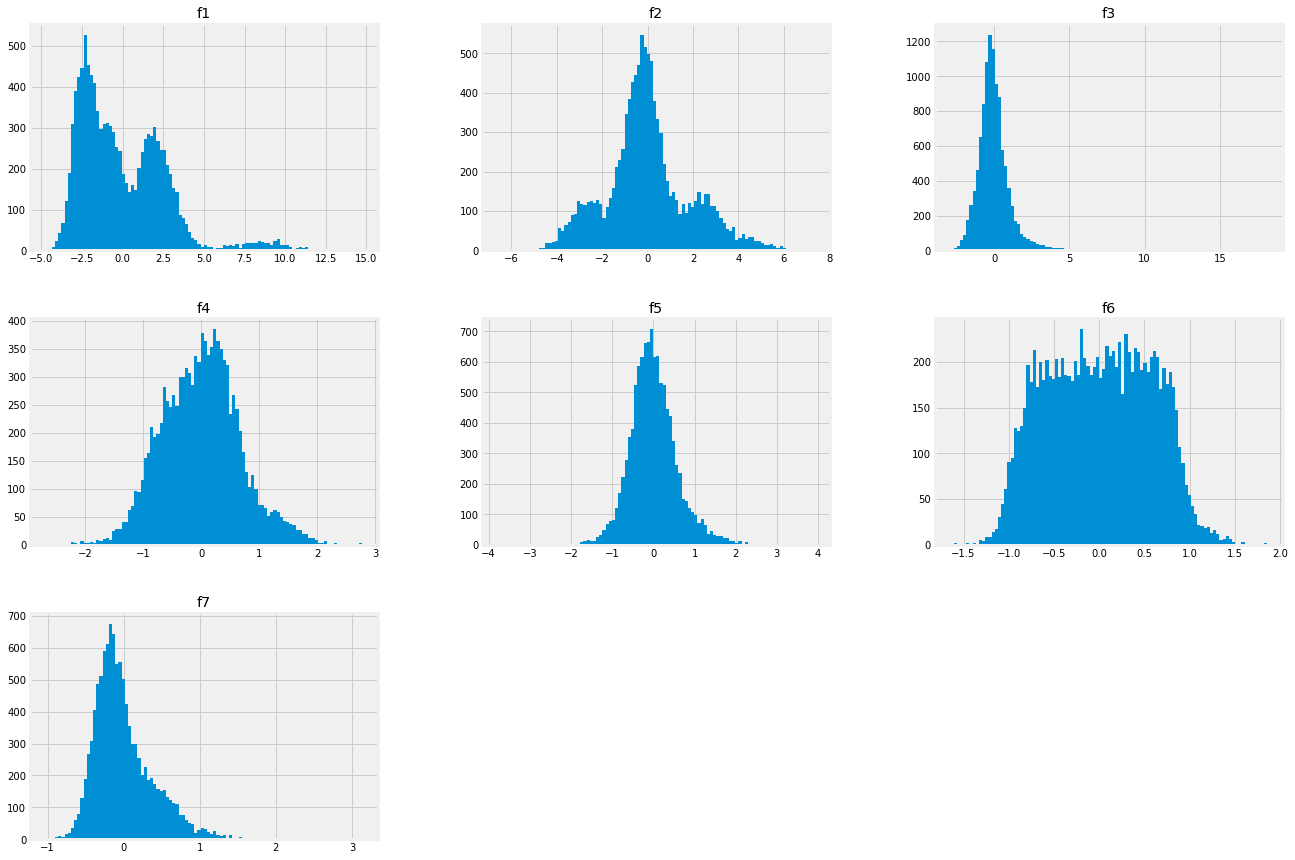

In [18]:
pca_df.hist(bins = 100, figsize = (20, 15));

,Feature,Skewness
0,f7,0.534281
1,f5,0.401098
2,f2,0.372880
3,f4,0.174126
4,f3,-0.119955
5,f1,-0.057466
6,f6,0.017057


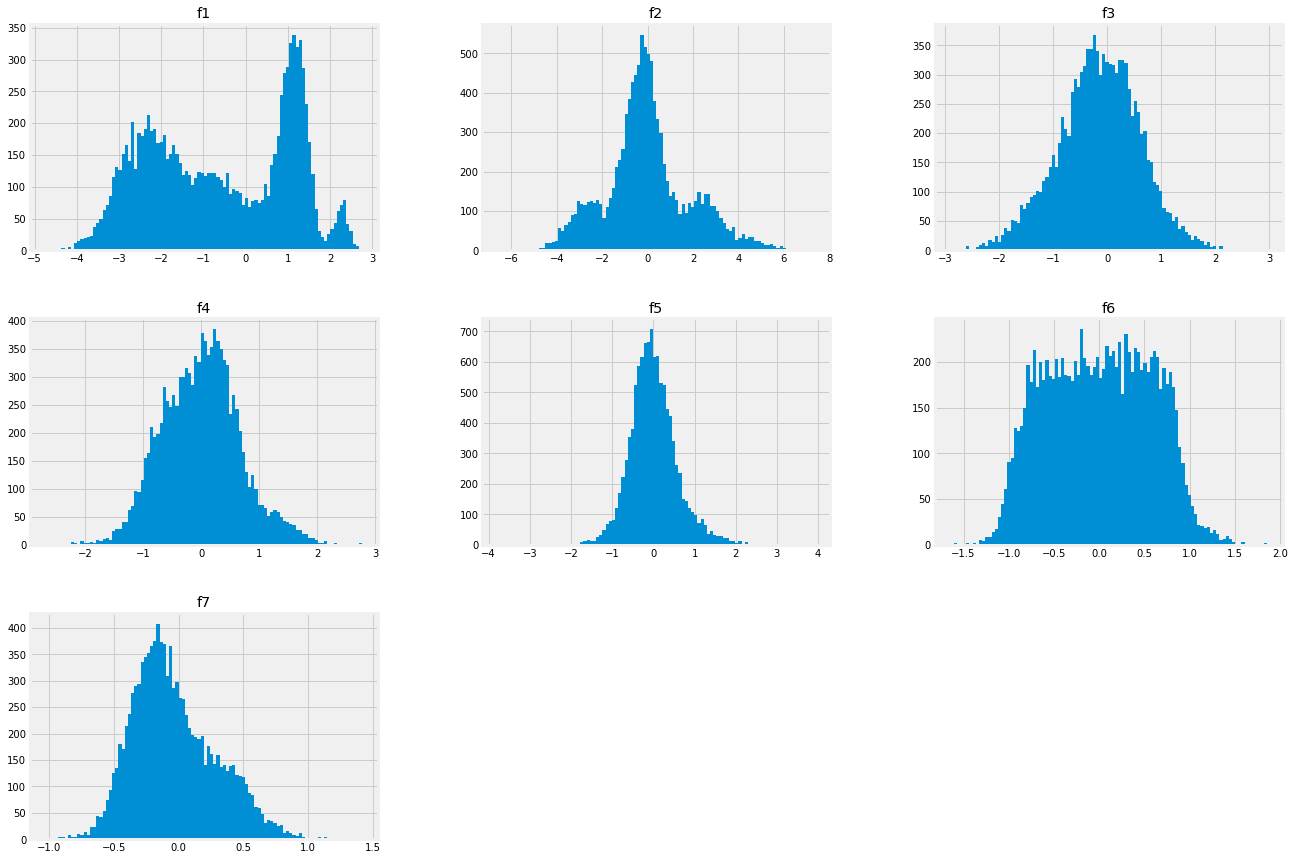

In [19]:
def skewness_calc(col ,df):
    std_col = np.std(df[col])
    mean_col = np.mean(df[col])
    size_rows = df.count()[0]
    df['diff_col'] = df[col] - mean_col
    df['diff_col_powered'] = np.power(df['diff_col'], 3)
    skewness = np.sum(df['diff_col_powered'])/((size_rows - 1) * np.power(std_col, 3))
    df = df.drop(columns = ['diff_col_powered', 'diff_col'], inplace = True)
    return skewness

def skewed_data_transformation(value, skewness):
    if (skewness >= 1 or skewness <= -1) and value >= 0:
        return np.log(1 + value)
    else:
        return value

feats = list(set(pca_df.columns.to_list()) - set(['y']))

for col in feats:
    sk = skewness_calc(col, pca_df)
    pca_df[col] = pca_df[col].apply(lambda x: skewed_data_transformation(x, sk))


pca_df.hist(bins = 100, figsize = (20, 15));


pca_df.skew().sort_values(key=abs, ascending=False).reset_index().rename(columns = {0 : 'Skewness', 'index' : 'Feature'})

In [20]:
df_train, df_val = train_test_split(pca_df, test_size=0.1, random_state=87)

X_train = df_train.drop(columns=['y'])
y_train = df_train[['y']]

X_val = df_val.drop(columns=['y'])
y_val = df_val[['y']]

print(f'X_train shape is: {X_train.shape}.')
print(f'X_val shape is: {X_val.shape}.')
print(f'y_train shape is: {y_train.shape}.')
print(f'y_val shape is: {y_val.shape}.')

X_train shape is: (9750, 7).
X_val shape is: (1084, 7).
y_train shape is: (9750, 1).
y_val shape is: (1084, 1).


In [21]:
classifier4 = SVC(random_state=0, probability=True)

classifier4 = classifier4.fit(X_train, y_train)
y_pred = classifier4.predict(X_val)

In [22]:
#Estimating accuracy using accuracy score

acc4 = accuracy_score(y_val, y_pred)

print (f'Accuracy = {acc4}')

Accuracy = 0.9455719557195572
